# Team 1: From black box to explanable AI: the trade-off between accuracy of complexity


In the project, we are exploring multiple machine learning methods spanning different ranges of explainability, complexity, and accuracy. Specifically, we will explore three types of machine learning models, which are neural networks (deterministic, black box), Gaussian process regression (probablistic, model data dependencies), and symbolic regression (output functions explicitly), and finally compare their performances on the accuracy-complexity axises.

# 0. Setup workspace and Import packages 

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point, performance_sigma_point_batched
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/ML_Project2_Team1


ImportError: cannot import name 'performance_sigma_point_batched' from 'lib.visual_figure4' (/home/jovyan/ML_Project2_Team1/lib/visual_figure4.py)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### PySR specific packages 

In [4]:
# load PySR
!pip install -U pysr

In [5]:
import pysr
import sympy
from pysr import PySRRegressor


/srv/conda/envs/notebook/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Data Preparation

In [6]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

In [7]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

In [8]:
mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)

started


In [9]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
valid_data = np.loadtxt(url, delimiter=None)[:,3:] 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [10]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 1. Neural Network

# 2. Gaussian Process

Gaussian Process (GP) can learn the probability distribution of the target function and make probabilistic predictions given new inputs. Compared with neural networks, GP inherently model the dependencies between different data points through a covariance function (kernel), and therefore the correlation between the shape function values at different positions can be modeled explicitly using the kernel function. **In this section, we aim to use Gaussian Process Regression (GPR) to predict the shape function values and examine whether accounting for data interdependencies could help increase the prediction accuracy. Following that, we will use SHAP (SHapley Additive exPlanations) analysis to identify the key features that contribute most to the model prediction.**  

In [ ]:
import torch
import gpytorch
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import shap
import time

## 2.1 Gaussian Process Regression

GP has very high computational complexicity that is proportional to the cube of the sample size O(n^3), making the training process impossible with over 900k samples (the server would explode in one sec). Therefore, we switch to Stochatic Variational Gaussian Process (SVGP) as an approximation of exact GP, which introduces variational inference (approximating intractable posterior distributions) and inducing points (a smaller set of pseudo-inputs to represent the full dataset) to speed up the calculation.

In [ ]:
# Define Approximate GP Model (SVGP)
class MultitaskSVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=500, input_dim=4, num_tasks=16):
        # Using variational inference method
        inducing_points = torch.randn(num_inducing, input_dim)
        
        batch_shape = torch.Size([num_tasks])
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks
        )
        
        super(MultitaskSVGPModel, self).__init__(variational_strategy)
        
        # Mean and kernel function
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Early stop when validation loss cease to decrease
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss, model, likelihood):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, likelihood)
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
    def save_checkpoint(self, model, likelihood):
        """Save the model checkpoint."""
        torch.save({
            'model_state_dict': model.state_dict(),
            'likelihood_state_dict': likelihood.state_dict()
        }, self.path)
        print(f'Model checkpoint saved to {self.path}')
        
    def load_checkpoint(self, model, likelihood):
        """Load the best model checkpoint."""
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])
        likelihood.load_state_dict(checkpoint['likelihood_state_dict'])
        return model, likelihood

### Data and model setup

In [ ]:
# Load Training Data
X = x  # Shape: (917858, 4)
Y = y  # Shape: (917858, 16)

# Normalize inputs to improve GP performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X.cpu().numpy())

# Convert to Torch tensors
X_train = torch.tensor(X_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

# Data Batch Loader Function
def get_batch_loader(X, Y, batch_size=1024, shuffle=True):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Prepare validation data
valid_x_scaled = scaler_X.transform(valid_x.cpu().numpy())
valid_x_tensor = torch.tensor(valid_x_scaled, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)

# Initialize Model
model = MultitaskSVGPModel(num_inducing=500, input_dim=4, num_tasks=16)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=16)

# Move to GPU
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    valid_x_tensor = valid_x_tensor.cuda()
    valid_y_tensor = valid_y_tensor.cuda()
    print("Training on GPU")

### Functions to save and load trained models

In [ ]:
def save_complete_model(model, likelihood, scaler, save_dir="saved_models"):
    """Save the complete model and all necessary components."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model and likelihood
    model_state = {
        'model_state_dict': model.state_dict(),
        'likelihood_state_dict': likelihood.state_dict(),
        'model_class': type(model).__name__,
        'model_config': {
            'num_inducing': model.variational_strategy.base_variational_strategy.inducing_points.shape[0],
            'input_dim': model.variational_strategy.base_variational_strategy.inducing_points.shape[1],
            'num_tasks': likelihood.num_tasks
        }
    }
    torch.save(model_state, os.path.join(save_dir, "complete_gp_model.pt"))
    
    # Save data processing components
    with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Complete model and components saved to {save_dir} directory.")

def load_model_for_prediction(model_dir="saved_models", device="cuda" if torch.cuda.is_available() else "cpu"):
    """Load saved models and related components for prediction."""
    model_state = torch.load(os.path.join(model_dir, "complete_gp_model.pt"), map_location=device)
    model_class = globals()[model_state['model_class']]
    config = model_state['model_config']
    model = model_class(
        num_inducing=config['num_inducing'],
        input_dim=config['input_dim'],
        num_tasks=config['num_tasks']
    )
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=config['num_tasks'])
    model.load_state_dict(model_state['model_state_dict'])
    likelihood.load_state_dict(model_state['likelihood_state_dict'])
    
    with open(os.path.join(model_dir, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    
    model = model.to(device)
    likelihood = likelihood.to(device)
    
    model.eval()
    likelihood.eval()
    
    return model, likelihood, scaler

### Training/Loading the trained model

In [ ]:
train_model = True

if train_model:
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}
    ], lr=0.01)

    # Use the Variational ELBO loss function
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.size(0))

    # Create data loaders
    train_loader = get_batch_loader(X_train, Y_train, batch_size=1024)
    valid_loader = get_batch_loader(valid_x_tensor, valid_y_tensor, batch_size=1024, shuffle=False)

    # Initialize early stopping
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "best_gp_model.pt")
    early_stopping = EarlyStopping(patience=10, path=model_path)

    # Initialize variables to track time and memory
    start_time = time.time()
    max_memory_allocated = 0

    # Training loop
    max_epochs = 50
    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        likelihood.train()
        train_epoch_loss = 0

        for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = -mll(output, Y_batch)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            # Update maximum memory allocated
            max_memory_allocated = max(max_memory_allocated, torch.cuda.max_memory_allocated())

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = train_epoch_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{max_epochs}, Avg Training Loss: {avg_train_loss:.4f}, Time: {epoch_time:.2f}s")

        # Validation phase
        model.eval()
        likelihood.eval()
        valid_epoch_loss = 0
        all_preds = [] 
        all_targets = [] 

        with torch.no_grad():
            for X_valid_batch, Y_valid_batch in valid_loader:
                output = model(X_valid_batch)
                loss = -mll(output, Y_valid_batch)
                valid_epoch_loss += loss.item()

        avg_valid_loss = valid_epoch_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Validation Loss: {avg_valid_loss:.4f}")

        # Check early stopping condition
        early_stopping(avg_valid_loss, model, likelihood)
        if early_stopping.early_stop:
            print("Early stopping triggered, stopping training!")
            break

    # Load the best model
    model, likelihood = early_stopping.load_checkpoint(model, likelihood)

    # Print total training time and maximum memory usage
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Max GPU Memory Allocated: {max_memory_allocated / 1024 ** 2:.2f} MB")
    
else:
    model, likelihood, scaler = load_model_for_prediction()

### Statistics

For the SVGP model, each epoch of batch training takes 175s, and traning stops at epoch 12 with an early stopping patience of 10.   **The total training time is 2139s (35.6 min) with 728 MB max GPU allocated memory.**  

On the validation dataset, the model achieves a RMSE of 0.5037.

In [ ]:
model.eval()
likelihood.eval()

valid_x_tensor = torch.tensor(valid_x_scaled, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)

all_preds = [] 
all_targets = []  

with torch.no_grad():
    for X_valid_batch, Y_valid_batch in valid_loader:
        output = model(X_valid_batch) 
        preds = output.mean 
        
        all_preds.append(preds.cpu())
        all_targets.append(Y_valid_batch.cpu())

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

mse = torch.mean((all_preds - all_targets) ** 2).item()
rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse:.4f}")

### Predictions

**The GPR predictions are superior to that of neural networks as a whole.** Figure (a) indicates that GPR-predicted normalized shape function values is more concentrated, especially for nodes 1~6 when comparing to neural networks. Figure (d) further confirms that most error distributions centers around 0 with a small peak width. The shape function in Figure (b) intuitively show that predicted values highly aligns with true values, and the spread of the first 8 nodes is minimal. For nodes 10-13, the improvement on prediction accuracy is insignificant, possibly due to the model's inability to fully capture the bimodal/multi-modal probability distribution as indicated in Figure (c). However, comparing to the wide error distribution of nodes 10-12 for neural networks, GBR predictions achieves much tighter error distribution with reduced overall bias.

In [ ]:
# Function performance_sigma_point_batched was added to visual_figure4.py and imported in section 0
performance_sigma_point_batched(model, x, valid_x, y, valid_y, k_mean, k_std)

## 2.2 SHAP Analysis

SHAP (SHapley Additive exPlanations) is an explainability technique for interpreting machine learning models. It is based on game theory and provides a way to fairly attribute the contribution of each feature to the model’s prediction. Specifically, it assigns feature importance by calculating the marginal contribution of different feature combinations to the model output.

In [ ]:
# Prepare test data
X_test = valid_x.cpu().numpy()
X_test_scaled = scaler_X.transform(X_test)

As SHAP values are computed for each sample, the size of the validation dataset (~900k samples) makes it impossible to do calculations over the full dataset. Here, we first use K-means clustering to select 100 representative samples as background dataset, and then randomly select 1000 samples to calculate SHAP values and identify feature importance.

In [ ]:
# Define a wrapper function to get predictions
def gp_model_predict_single_output(X, output_index):
    X_torch = torch.tensor(X, dtype=torch.float32).to(next(model.parameters()).device)
    with torch.no_grad():
        preds = likelihood(model(X_torch))  # GP prediction
    return preds.mean[:, output_index].cpu().numpy()  # Extract one output dimension

shap_values_list = []
np.random.seed(42)

for output_index in range(16):
    print(f"Computing SHAP values for output {output_index+1}/16")
    # K-means to select 100 representatives as background
    X_sample = shap.kmeans(X_test_scaled, 100)
    explainer = shap.KernelExplainer(lambda x: gp_model_predict_single_output(x, output_index), X_sample)
    
    # Randomly get 1000 samples for testing
    X_explained = shap.sample(X_test_scaled, 1000)
    shap_values = explainer.shap_values(X_explained)  
    shap_values_list.append(shap_values)

### SHAP Summary Plots

SHAP summary plots provide insights into how different features (I0, b00, h0, ustar0) impact the model’s predictions. These plots are arranged based on following principles:  
1. Feature Importance: The features are sorted by importance, with **the most impactful feature appearing at the top**;
2. SHAP Values: The X-axis represents SHAP values, which measure the magnitude and direction of a feature’s effect on the model’s prediction (**positive SHAP values indicate that the feature increases the model's output and vice versa**);
3. Feature Values: The color gradient (blue to red) represents the feature values, which are raw input to the model (e.g., actual h0 value). **Blue = low feature values, Red = high feature values**.

From the SHAP summary plots shown below, several patterns could be observed:  
1. The SHAP values for different features generally have wide spreads, indicating the influence varies significantly across different samples.
2. **For the first 11 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00).** Low I0 values tend to decrease the prediction while high I0 values tend to increase it. As depth increases, the distribution of I0 SHAP values becomes more skewed as the contribution of high I0 values becomes more insignificant and gradually centers around 0. At the same time, low I0 values consistently show strong negative effects on model predictions.
3. **For the last 5 locations, Surface buoyancy flux (b00) becomes the most significant feature.** The influence of b00 is highly nonlinear, with low values increasing model output, middle values having negligible effects and high values decreasing model output.

In [ ]:
num_positions = 16
interval = 1
selected_indices = list(range(0, num_positions, interval))

for idx in selected_indices:
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_list[idx], X_explained, feature_names=['l0', 'b00', 'ustar0', 'h0'], show=False )
    plt.gcf().suptitle(f"SHAP Summary - Position {idx + 1}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1.1])
    plt.show()
    plt.close()

### Feature Importance Map

**The absolute values of SHAP values reflects the magnitude of influence for different features.** It can be seen from the map below that Coriolis force (I0) dominates the prediction for the upper ocean (first 11 locations) while Surface buoyancy flux (b00) plays a more important role for lower-level ocean shape function values. 

In [ ]:
# Calculate average absolute SHAP value for each feature across all positions
all_importances = np.zeros((len(shap_values_list), len(feature_names)))

for i, shap_values in enumerate(shap_values_list):
    all_importances[i] = np.abs(shap_values).mean(axis=0)

# Feature Importance Heatmap
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(
    all_importances.T,  # Transpose for better visualization
    cmap="YlOrRd",
    yticklabels=feature_names,
    xticklabels=[f"Pos {i+1}" for i in range(all_importances.shape[0])],
    cbar_kws={'label': 'Mean |SHAP value|'}
)

plt.title("Feature Importance by Position")
plt.tight_layout()
plt.show()
plt.close()

### Global Feature Importance

Averaging across 16 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00). Surface friction velocity (ustar0) also impact predictions, while boundary layer depth (h0) has the least effect.

In [ ]:
# Average across all positions
avg_importance = all_importances.mean(axis=0)

colors = sns.color_palette("coolwarm_r", len(avg_importance))
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_names, avg_importance, color=colors, edgecolor="black")
plt.xlabel("Mean |SHAP Value|", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("Global Feature Importance Across All Positions", fontsize=16, fontweight="bold", pad=10)
plt.gca().invert_yaxis() 
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Above results show that accounting for data interdependencies by adopting Gaussian process greatly increases shape function prediction accuracy, and adding SHAP analysis after ML models helps further identify feature interactions and importance. Such combined approach offers enhanced accuracy and explanability over pure black-box ML models.  

However, the computational complexity makes it impossible to carry out exact GP process, and SHAP values cannot be calculated for the whole dataset. In addition, SHAP results have shown large spread for different features, making it difficult to draw consistent conclusions and imposing constraints on the acquired explanability. 

# 3. Symbolic Regression

**Symbolic Regression** is a machine learning method that discovers mathematical expressions that best describe a given dataset. Whereas neural networks rely on an uninterpretable series of computations—often referred to as a "black box"—symbolic regression produces a set of equations of increasing complexity that are readable and interpretable by humans. However, this interpretability comes at increased computational cost. Models take significantly longer to run as the method searches through a vast space of possible equations, making it less scalable for high-dimensional or large datasets.


In this project we are utilizing **PySR (Python Symbolic Regression)**, an open-source package designed by Miles Cramner for efficient symbolic regression. For more information refer to *Cranmer 2023*:

*Cranmer, M. (2023). Interpretable machine learning for science with PySR and SymbolicRegression. jl. arXiv preprint arXiv:2305.01582*.


## 3.1 Model 1: Normalized Inputs

In our first attempt, we modeled the set up of the initial neural network from *Sane et al. (2023)* with the four input physical parameters ($ \mathcal{N}_1 $.) to predict $ g(\sigma) $ at 16 depth parameters. The resulting model produces 16 separate equations of varying complexity, each corresponding to one of the original 16 depth nodes.

PySR allows users to define both simple binary and complex unary operators. However, incorporating additional operators significantly increases computation time. To minimize lengthy model runs while still selecting unary operators, we performed symbolic regression on a subset of grid cells using a predefined set of operators: 'square,' 'exp,' 'sin,' 'cos,' 'neg,' 'sqrt,' and 'log.' Based on the performance of the models, we selected 'square' and 'sin' for all of our final models, as these operators were most commonly used in the best-performing equations.

In [11]:
## convert tensor object back to numpy array 

x = x.cpu().numpy()
y = y.cpu().numpy()

valid_x = valid_x.cpu().numpy()
valid_y = valid_y.cpu().numpy()




In [29]:
# Define the output directory
output_dir = "/home/jovyan/ML_Project2_Team1/pysrmods"

cwd_pysrout = cwd + '/pysrout/'

print(cwd_pysrout)


/home/jovyan/ML_Project2_Team1/pysrout/


In [13]:
## model set up

default_pysr_params = dict(
    populations=30,  # default
    model_selection="best", ## 'best' selects the candidate model with the highest score among expressions with a loss better than at least 1.5x the most accurate model. 
)

# Create the PySRRegressor model with output directory
model = PySRRegressor(
    niterations=30,  # Reduced from 100 for computation time  
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["square", "sin"], 
    **default_pysr_params,
    batching=True,  # Enable batching  
    batch_size=64,
    verbosity=0,  # Suppress output - this can bog down the notebook
    output_directory=cwd_pysrout,  # Set output directory here
)


In [14]:
# NOTE : we have commented this out as running the model can take a long time
## in the next cell we are going to load a previous model
#model.fit(x, y) 

/srv/conda/envs/notebook/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       2.4957185e-6   
	1         0.046815                                    x0 * 0.29490986   
	2         0.046712                                sin(x0) / 2.0314455   
	3         0.046115                               sin(square(x0)) / x0   
	4   >>>>  0.092479                         sin(x0 / (x0 + 1.2237585))   
	5         0.001823                    sin(sin(x0 / (x0 + 1.2287738)))   
	6         0.007552          sin(x0 / ((x0 + 2.7642353) * 0.59714323))   
	7         0.004747    sin(((x0 / 1.2237585) + x0) / (x0 + 2.7530184))   
	8         0.000842   (sin(x0 + x0) + sin(x1 - 0.6757509)) * 0.6805366   
	9         0.000511  sin(((square(square(x0)) / x0) - (-0.3807395 *...   
	10        0.003490  sin(((0.5863865 * square(square(x0))) / x0) - ...   
	11        0.031952  sin(sin(square(x0) - -0.15043259) * (x0 - ((x1...   
	12        0.004515  sin(((0.53195274 / x0) * square(square(x0))) -...   
	
	        loss  complexity  
	0   1.000000           1  
	1   0.910619           3  
	2   0.869060           4  
	3   0.829894           5  
	4   0.756588           6  
	5   0.755210           7  
	6   0.749528           8  
	7   0.742447          10  
	8   0.741822          11  
	9   0.741443          12  
	10  0.738860          13  
	11  0.715625          14  
	12  0.712401          15  
], [
	    pick     score                                           equation  \
	0         0.000000                                       0.0001632276   
	1   >>>>  0.351314                                            sin(x0)   
	2         0.024784                                       sin(sin(x0))   
	3         0.015601                                sin(x0) * 0.7661646   
	4         0.118419                                  sin(x0 + sin(x1))   
	5         0.039220                       sin(x0 - (x1 * -0.52618647))   
	6         0.002454                     sin(x0 + sin(x1 * 0.68072957))   
	7         0.006332          sin(x0 + ((x1 * 0.5021644) - 0.07569894))   
	8         0.002635      sin(x0 + sin((x1 * 0.68072957) - 0.13215078))   
	9         0.069873  sin((x1 + (1.44413 - square(0.8666958 - x0))) ...   
	10        0.001464  sin(((1.44413 - square(x0 - 0.8666958)) + x1) ...   
	11        0.004989  sin(((x0 + (x1 - -0.6494128)) - square(0.43475...   
	12        0.008338  sin(((x0 + (x1 - -1.2015238)) - square(0.56358...   
	13        0.001733  sin((((0.34874505 - (x0 / -0.5323164)) - (x0 *...   
	
	        loss  complexity  
	0   1.000000           1  
	1   0.703763           2  
	2   0.686535           3  
	3   0.675908           4  
	4   0.600425           5  
	5   0.577332           6  
	6   0.575917           7  
	7   0.572282           8  
	8   0.570776           9  
	9   0.496335          11  
	10  0.495609          12  
	11  0.493143          13  
	12  0.484987          15  
	13  0.477482          24  
], [
	    pick     score                                           equation  \
	0         0.000000                                        3.941425e-9   
	1         0.156758                                            sin(x1)   
	2         0.053072                                      x1 * 0.431602   
	3         0.006168                                sin(x1 * 0.5738731)   
	4   >>>>  0.240733                              (x0 + x1) * 0.4203793   
	5         0.012032                         sin((x0 + x1) * 0.5180357)   
	6         0.118479                      ((x0 + x1) - x2) * 0.37846044   
	7         0.006484      (x1 + (x0 + (x2 * -0.62966394))) * 0.45436603   
	8         0.122602  (((x0 - 0.97124016) + x1) + square(x2)) / 2.98...   
	9         0.000095  ((x0 - sin(1.4965949)) + (x1 + square(x2))) / ...   
	10        0.023073  (((x0 + x1) * 2.5939388) - (1.3762853 - square...   
	11        0.019276  ((x1 + (x0 - -1.9357764)) * 0.41916654) - sin(...   
	12        0.001600  (((x1 + (0.107

In [23]:
# Define the run_directory. 
#ML_Project2_Team1/pysrout/20250325_025749_EpCfJx

run_directory = cwd_pysrout + "/20250325_025749_EpCfJx" ## this file extention refers to the most recent model. 

print(run_directory)

# Load model from the checkpoint - this can be finnicky, double check your file paths if you recieve an error
model = PySRRegressor.from_file(run_directory=run_directory)

Attempting to load model from /home/jovyan/ML_Project2_Team1/pysrout/20250325_025749_EpCfJx/checkpoint.pkl...


/home/jovyan/ML_Project2_Team1/pysrout//20250325_025749_EpCfJx


In [24]:
## look at all equations for every depth
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       2.4957185e-6   
	1         0.046815                                    x0 * 0.29490986   
	2         0.046712                                sin(x0) / 2.0314455   
	3         0.046115                               sin(square(x0)) / x0   
	4   >>>>  0.092479                         sin(x0 / (x0 + 1.2237585))   
	5         0.001823                    sin(sin(x0 / (x0 + 1.2287738)))   
	6         0.007552          sin(x0 / ((x0 + 2.7642353) * 0.59714323))   
	7         0.004747    sin(((x0 / 1.2237585) + x0) / (x0 + 2.7530184))   
	8         0.000842   (sin(x0 + x0) + sin(x1 - 0.6757509)) * 0.6805366   
	9         0.000511  sin(((square(square(x0)) / x0) - (-0.3807395 *...   
	10        0.003490  sin(((0.5863865 * square(square(x0))) / x0) - ...   
	11        0.031952  sin(sin(square(x0) - -0.15043259) * (x0 - ((x1...   
	12    

### 3.1.1 Model 1: Figures

In [16]:
## redefine the plotting code from Sane et al. so that it can use the pysr predict function
def get_hist(y, k_mean, k_std):
    """Get histogram values for normalized data."""
    vals, binss = np.histogram(np.exp(y * k_std + k_mean), range=(0, 1.2), bins=100)
    return vals, 0.5 * (binss[0:-1] + binss[1:])

def get_hist2(y):
    """Get histogram values for error data."""
    vals, binss = np.histogram(y, range=(-0.2, 0.2), bins=100)
    return vals, 0.5 * (binss[0:-1] + binss[1:])

def performance_sigma_point2(model, x, valid_x, y, valid_y, k_mean, k_std):
    """Plot the performance of a neural network model.

    Parameters:
        model: Trained neural network model.
        x: Training input data.
        valid_x: Validation input data.
        y: Training output data (NumPy array).
        valid_y: Validation output data (NumPy array).
        k_mean: Mean normalization values.
        k_std: Standard deviation normalization values.
    """
    # plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['font.size'] = 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'  # ensures it can math compatibility with symbols in your code without erroring fix no cursive_fontsystem

    y_pred_train = model.predict(x)
    y_pred_test = model.predict(valid_x)

    # Since y, valid_y, y_pred_train, and y_pred_test are NumPy arrays, no need for .cpu() or .detach()
    ycpu = y
    ytestcpu = valid_y
    yptraincpu = y_pred_train
    yptestcpu = y_pred_test

    ystd = np.zeros(16)
    yteststd = np.zeros(16)
    ypstd = np.zeros(16)
    ypteststd = np.zeros(16)
    yerr = np.zeros(16)
    kappa_mean = np.zeros(16)

    for i in range(16):
        ystd[i] = np.std(np.exp(ycpu[:, i] * k_std[i] + k_mean[i]))
        yteststd[i] = np.std(np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]))
        ypstd[i] = np.std(np.exp(yptraincpu[:, i] * k_std[i] + k_mean[i]))
        ypteststd[i] = np.std(np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]))
        yerr[i] = np.std(np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]))

        kappa_mean[i] = np.mean(np.exp(ycpu[:, i] * k_std[i] + k_mean[i]))

    plt.figure(figsize=(15, 10))

    ind = np.arange(0, 16)
    ind_tick = np.arange(1, 17)[::-1]

    # Subplot 1: Boxplot of network output differences
    plt.subplot(1, 4, 1)
    for i in range(16):
        plt.boxplot(ytestcpu[:, i] - yptestcpu[:, i], vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
    plt.xlim([-2.0, 2.0])
    plt.yticks(ind, ind_tick)
    plt.title(r'(a) Output of network $\mathcal{N}_1$ ')
    plt.ylabel('Node')

    # Subplot 2: Boxplot of shape function differences
    plt.subplot(1, 4, 2)
    for i in range(16):
        plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                    vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
    plt.yticks([])
    plt.title(r'(b) Shape function $g(\sigma)$')
    plt.xlabel(r'$g(\sigma)$')

    # Subplots 3 & 4: Histograms
    k12 = 15
    for k in range(16):
        plt.subplot(16, 4, 4 * k + 3)
        vals, binss = get_hist(ytestcpu[:, k12], k_mean[k12], k_std[k12])
        plt.plot(binss, vals, color='blue')

        vals, binss = get_hist(yptestcpu[:, k12], k_mean[k12], k_std[k12])
        plt.plot(binss, vals, color='red')
        if k < 15:
            plt.xticks([])
        plt.yticks([])
        if k == 0:
            plt.title('(c) Probability density histogram')

        plt.subplot(16, 4, 4 * k + 4)
        vals, binss = get_hist2(np.exp(ytestcpu[:, k12] * k_std[k12] + k_mean[k12]) - np.exp(yptestcpu[:, k12] * k_std[k12] + k_mean[k12]))
        plt.plot(binss, vals, color='green')
        if k < 15:
            plt.xticks([])
        plt.yticks([])
        if k == 0:
            plt.title('(d) Error histogram ')

        k12 -= 1

    plt.tight_layout()
    # print("Plot saved as 'modelstats.pdf'")



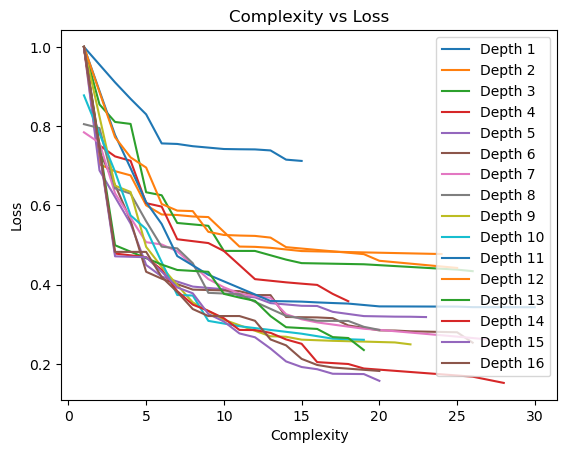

In [17]:
## complexity versus loss plots

# Loop through each depth in model.equations_
for i in range(len(model.equations_)):
    depth1 = model.equations_[i]  # Extract the current depth's data

    # Extract the values for complexity and loss
    complexity_values = depth1['complexity']
    loss_values = depth1['loss']

    # Create a line plot
    plt.plot(complexity_values, loss_values, label=f'Depth {i+1}')

# Labels and title
plt.xlabel('Complexity')
plt.ylabel('Loss')
plt.title('Complexity vs Loss')

# Add legend
plt.legend()

# Show plot
plt.show()


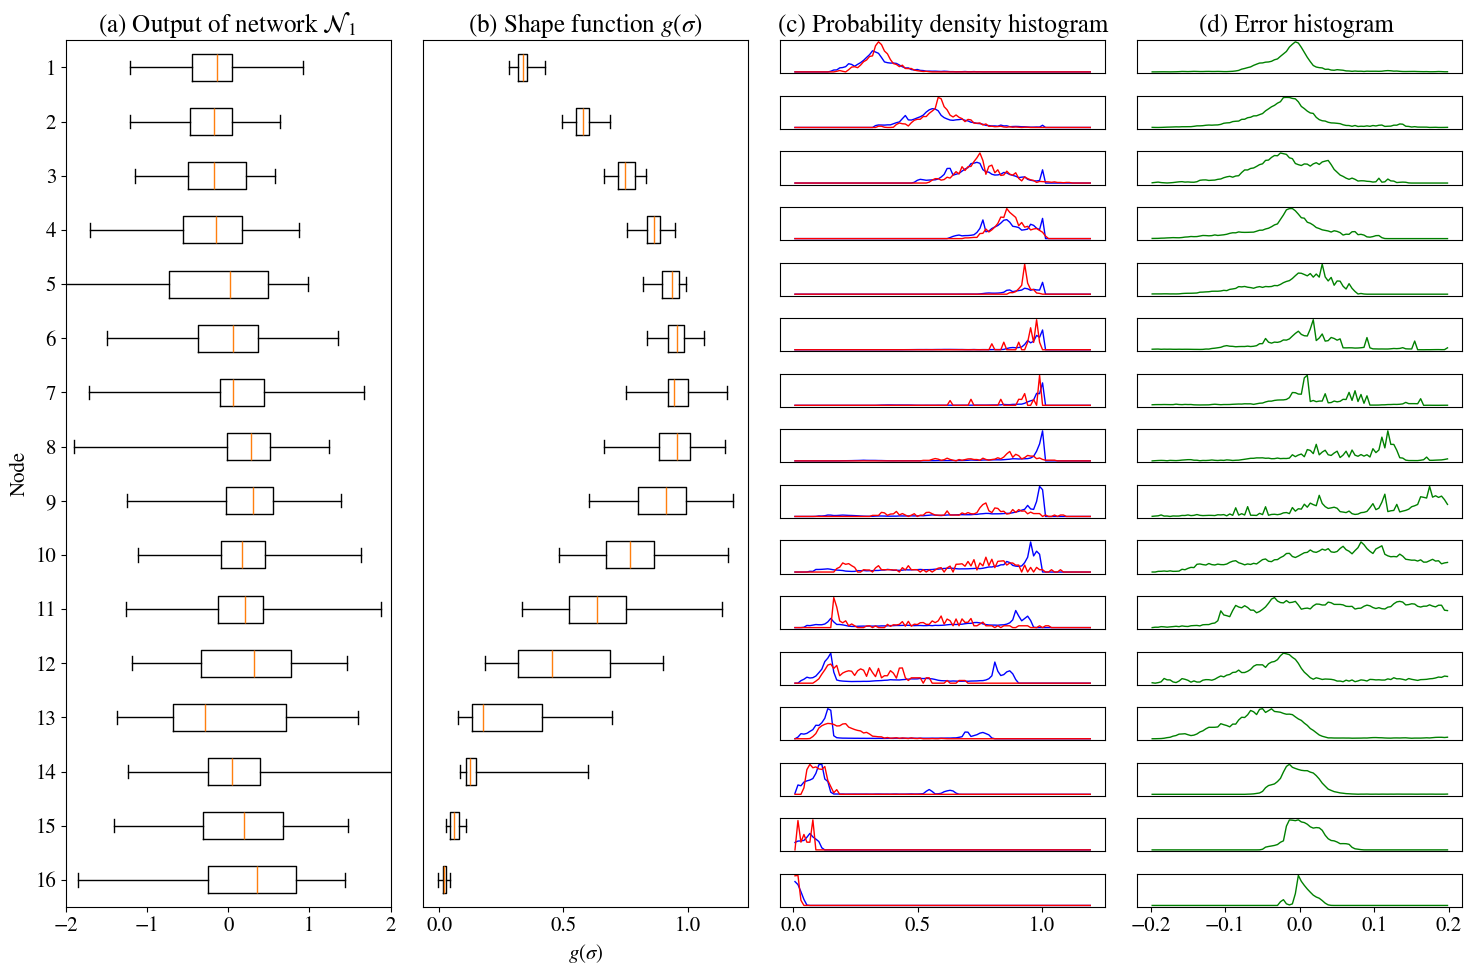

In [19]:
## figure histograms 
performance_sigma_point2(model, x, valid_x, y, valid_y, k_mean, k_std)

**Symbolic regression performed worse than the other machine learning methods in both predictive accuracy and computational speed**. Error bars in both box and whisker plots reveal large variability within the predictions and running the model requires 80–120 minutes to run. **However, where it lacks in performance it makes up in interpretability**. The resulting equations are easy to understand and can be seamlessly integrated into larger ecosystem models without significant computational cost. 

There are additional measures that could possibly improve overall performace, such as increasing the number of iterations or including more unary operators within the equation search. However, with each you will be increasing computational cost even further


### 3.1.2 Model 1: Statistics

In [20]:
y_pred_test = model.predict(valid_x)

rmse = np.sqrt(np.mean((y_pred_test - valid_y) ** 2))

print("RMSE:", rmse)

RMSE: 0.8644306002927096


In [21]:
# Denormalize predicted and observed values
y_pred_denorm = np.std(np.exp(y_pred_test * k_std + k_mean))
valid_y_denorm = np.std(np.exp(valid_y * k_std + k_mean))

# RMSE calculation 
rmse = np.sqrt(np.mean((y_pred_denorm - valid_y_denorm) ** 2))

print("RMSE (denormalized):", rmse)

RMSE (denormalized): 0.01629994229621362


## 3.2 Model 2: Raw Inputs 

In our original hypothesis, we assumed that normalizing the data during preprocessing was unnecessary since symbolic regression does not rely on gradient descent. However, due to the large discrepancies in the raw, unnormalized data, we found that the varying scales of input parameters disproportionately influenced the search process, causing some underlying relationships to be overlooked.

### 3.2.1 Data and Model Preparation

In [25]:
def preprocess_train_pysr(data_load):
    # Compute means and standard deviations for the first 4 columns (features)
    l_mean, l_std = np.mean(data_load[:, 0]), np.std(data_load[:, 0])
    h_mean, h_std = np.mean(data_load[:, 1]), np.std(data_load[:, 1])
    t_mean, t_std = np.mean(data_load[:, 2]), np.std(data_load[:, 2])
    hb_mean, hb_std = np.mean(data_load[:, 3]), np.std(data_load[:, 3])

    # Compute means and standard deviations for the output columns
    k_mean = np.mean(data_load[:, 4:], axis=0)
    k_std = np.std(data_load[:, 4:], axis=0)

    # Split into inputs (x) and outputs (y) without modifying the original values
    x = data_load[:, :4]   # First 4 columns as input features
    y = data_load[:, 4:]   # Remaining columns as output labels

    # Store feature statistics
    stats = np.array([l_mean, l_std, h_mean, h_std, t_mean, t_std, hb_mean, hb_std])

    return data_load, x, y, stats, k_mean, k_std


In [26]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')


## we do not need to normalize data for this process 
data, x,y, stats, k_mean, k_std=preprocess_train_pysr(data_load3)  


started


In [27]:
# loading the validation data wihtout normalization

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df.iloc[:, 3:].values  

# Filtering the data
ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)

# Extract features without normalization
valid_x = valid_data[ind, 0:4]  

# Extract targets without log transformation or normalization
valid_y = valid_data[ind, 5:]  

# No standardization, no log transformation
k_mean_test = np.zeros(16)  


In [28]:
## model set up is same as before 

default_pysr_params = dict(
    populations=30,  # default
    model_selection="best", ## 'best' selects the candidate model with the highest score among expressions with a loss better than at least 1.5x the most accurate model. 
)

# Create the PySRRegressor model with output directory
model = PySRRegressor(
    niterations=30,  # Reduced from 100 for computation time  
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["square", "sin"], 
    **default_pysr_params,
    batching=True,  # Enable batching  
    batch_size=64,
    verbosity=0,  # Suppress output - this can bog down the notebook
    output_directory=cwd_pysrout,  # Set output directory here
)


In [30]:
# NOTE : we have commented this out as running the model can take a long time
## in the next cell we are going to load a previous model
#model.fit(x, y) 

/srv/conda/envs/notebook/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       0.0034946378   
	1         0.015110                                    x2 * 0.15091008   
	2         0.019587                           square(x2 + 0.036893304)   
	3   >>>>  0.257981                  (x1 / 3.329513e-5) + 0.0034743338   
	4         0.019981              ((193.9641 * x3) * x1) + 0.0032672682   
	5         0.016028     ((x3 / 0.0069845705) * x1) + (0.12892564 * x2)   
	6         0.008518  ((x3 * (x1 * 193.9641)) + square(x2)) + 0.0023...   
	7         0.052534  ((193.9641 * x1) * x3) + ((0.15100126 * x2) + x0)   
	8         0.019263  square(x2 + (((x1 * 1755.8552) + (x0 + x0)) * ...   
	9         0.000056  sin(square(x2 + (((x1 * 1755.8552) + (x0 + x0)...   
	10        0.005241  x0 + square(x2 + ((((x1 * 1755.8552) + x0) + x...   
	11        0.003796  x0 + square(sin(x2 + (((x1 * 1755.8552) + (x0 ...   
	12        0.057799  square(sin(x0 + ((x3 * (x0 + (x1 * 1755.8552))...   
	
	        loss  complexity  
	0   0.000016           1  
	1   0.000016           3  
	2   0.000016           4  
	3   0.000012           5  
	4   0.000012           7  
	5   0.000011           9  
	6   0.000011          10  
	7   0.000011          11  
	8   0.000010          12  
	9   0.000010          13  
	10  0.000010          14  
	11  0.000010          15  
	12  0.000009          17  
], [
	    pick     score                                           equation  \
	0         0.000000                                        0.011927908   
	1         0.085520                                            x3 * x0   
	2         0.000046                                       sin(x3 * x0)   
	3         0.245254                   0.01244074 + (x1 / 1.4371699e-5)   
	4   >>>>  0.140625             (x2 + (x1 / 7.080205e-6)) * 0.55022526   
	5         0.010427  (x2 * 0.5218202) + ((x1 / -0.65346) / -1.61996...   
	6         0.004733  ((x1 / -0.65346) / (x1 + -1.6199636e-5)) + (x2...   
	7         0.004687  (x2 * 0.5218202) + ((x1 / -0.65346) / ((x1 + x...   
	8         0.003035  (x2 + ((x1 + x1) / 1.3897986e-5)) * square(-0....   
	9         0.112529  ((x1 / -0.65346) / ((x1 + (x1 / 0.07061858)) +...   
	10        0.007994  ((x1 + x1) / 1.4283509e-5) + (square((x1 / (x1...   
	11        0.067925  x1 + (0.5487073 * (x2 + ((x1 + x1) / ((x1 / ((...   
	12        0.001415  (x2 + ((x1 + x1) / 1.3897986e-5)) * ((x1 / (x2...   
	13        0.006951  (x2 + ((x1 + x1) / 1.3897986e-5)) * (square(((...   
	
	        loss  complexity  
	0   0.000113           1  
	1   0.000095           3  
	2   0.000095           4  
	3   0.000074           5  
	4   0.000056           7  
	5   0.000055           9  
	6   0.000055          11  
	7   0.000054          13  
	8   0.000054          14  
	9   0.000048          15  
	10  0.000047          18  
	11  0.000044          19  
	12  0.000043          26  
	13  0.000043          29  
], [
	    pick     score                                           equation  \
	0         0.000000                                        0.028930247   
	1         0.000077                                   x0 + 0.028851494   
	2         0.186987                  (x1 + 7.410483e-8) / 2.6213568e-6   
	3         0.000150           ((x1 + 7.410483e-8) / 2.6213568e-6) + x0   
	4         0.001341  ((x1 + 7.410483e-8) / 2.6213568e-6) + (x0 / 0....   
	5   >>>>  0.229752  (8.993866e-8 + x1) / ((x2 / square(x3)) + 1.62...   
	6         0.000944  (8.993866e-8 + x1) / (1.6209152e-6 + (x2 / squ...   
	7         0.006694  ((x1 + 8.993866e-8) / ((x2 / square(x3)) + 1.6...   
	8         0.000155  (((8.993866e-8 + x1) / (1.6209152e-6 + (x2 / s...   
	9         0.011453  (x1 / ((((0.0008771643 - (((x1 / 0.0008771643)...   
	10        0.039675  sin(sin((x1 / (((((0.0008771643 - ((x1 / 0.000...   
	11        0.000286  sin(sin(sin((x1 / (((((0.0008771643 - ((x1 / 0...   
	
	        loss  complexity  
	0   

In [ ]:
# Define the run_directory. 
#ML_Project2_Team1/pysrout/20250325_044928_9qA1hR

run_directory = cwd_pysrout + "/20250325_044928_9qA1hR" ## this file extention refers to the most recent model. 

print(run_directory)

# Load model from the checkpoint - this can be finnicky, double check your file paths if you recieve an error
model = PySRRegressor.from_file(run_directory=run_directory)

In [38]:
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       0.0034946378   
	1         0.015110                                    x2 * 0.15091008   
	2         0.019587                           square(x2 + 0.036893304)   
	3   >>>>  0.257981                  (x1 / 3.329513e-5) + 0.0034743338   
	4         0.019981              ((193.9641 * x3) * x1) + 0.0032672682   
	5         0.016028     ((x3 / 0.0069845705) * x1) + (0.12892564 * x2)   
	6         0.008518  ((x3 * (x1 * 193.9641)) + square(x2)) + 0.0023...   
	7         0.052534  ((193.9641 * x1) * x3) + ((0.15100126 * x2) + x0)   
	8         0.019263  square(x2 + (((x1 * 1755.8552) + (x0 + x0)) * ...   
	9         0.000056  sin(square(x2 + (((x1 * 1755.8552) + (x0 + x0)...   
	10        0.005241  x0 + square(x2 + ((((x1 * 1755.8552) + x0) + x...   
	11        0.003796  x0 + square(sin(x2 + (((x1 * 1755.8552) + (x0 ...   
	12    

### 3.2.2 Figures

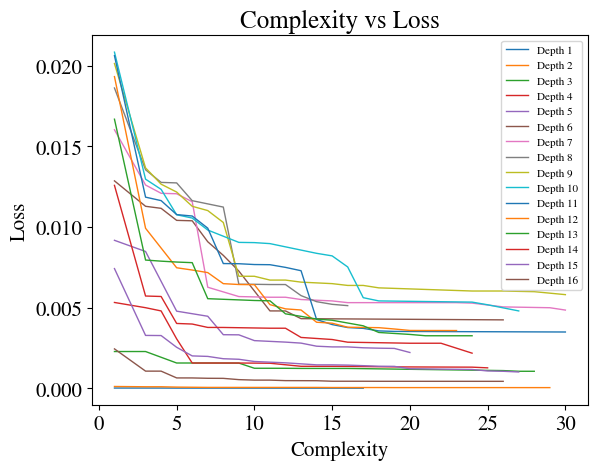

In [33]:
# Loop through each depth in model.equations_
for i in range(len(model.equations_)):
    depth1 = model.equations_[i]  # Extract the current depth's data

    # Extract the values for complexity and loss
    complexity_values = depth1['complexity']
    loss_values = depth1['loss']

    # Create a line plot
    plt.plot(complexity_values, loss_values, label=f'Depth {i+1}')

# Labels and title
plt.xlabel('Complexity')
plt.ylabel('Loss')
plt.title('Complexity vs Loss')

# Add legend
plt.legend()

# Show plot
plt.show()


In [36]:
def performance_mod2(model, x, valid_x, y, valid_y):

    # Set plot styles
    plt.rcParams['font.size'] = 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'

    # Get predictions
    y_pred_test = model.predict(valid_x)

    plt.figure(figsize=(8, 10))  

    ind = np.arange(0, 16)
    ind_tick = np.arange(1, 17)[::-1]

    # Subplot 1: Boxplot of network output differences
    plt.boxplot(
        [valid_y[:, i] - y_pred_test[:, i] for i in range(16)], 
        vert=False, 
        positions=ind, 
        showfliers=False, 
        whis=(5, 95), 
        widths=0.5
    )

    plt.xlim([-0.5, 0.5])
    plt.yticks(ind, ind_tick)
    plt.title(r'(a) Output of network $\mathcal{N}_1$')
    plt.ylabel('Node')
    plt.xlabel('Difference (True - Predicted)')

    plt.tight_layout()
    plt.show()


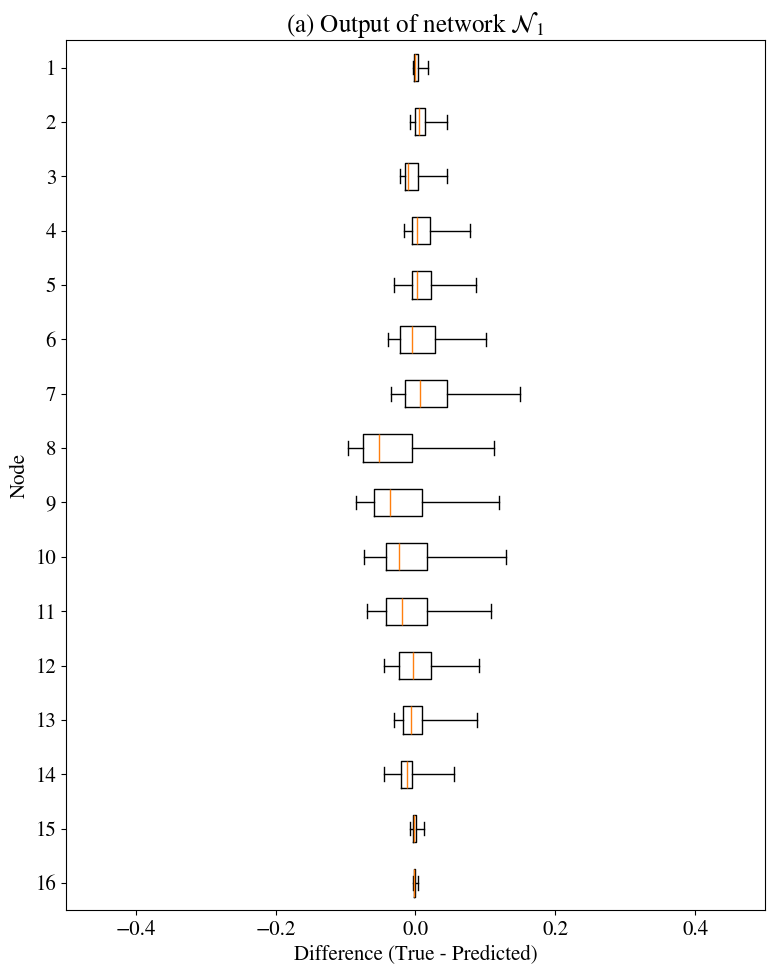

In [35]:
performance_mod2(model, x, valid_x, y, valid_y)

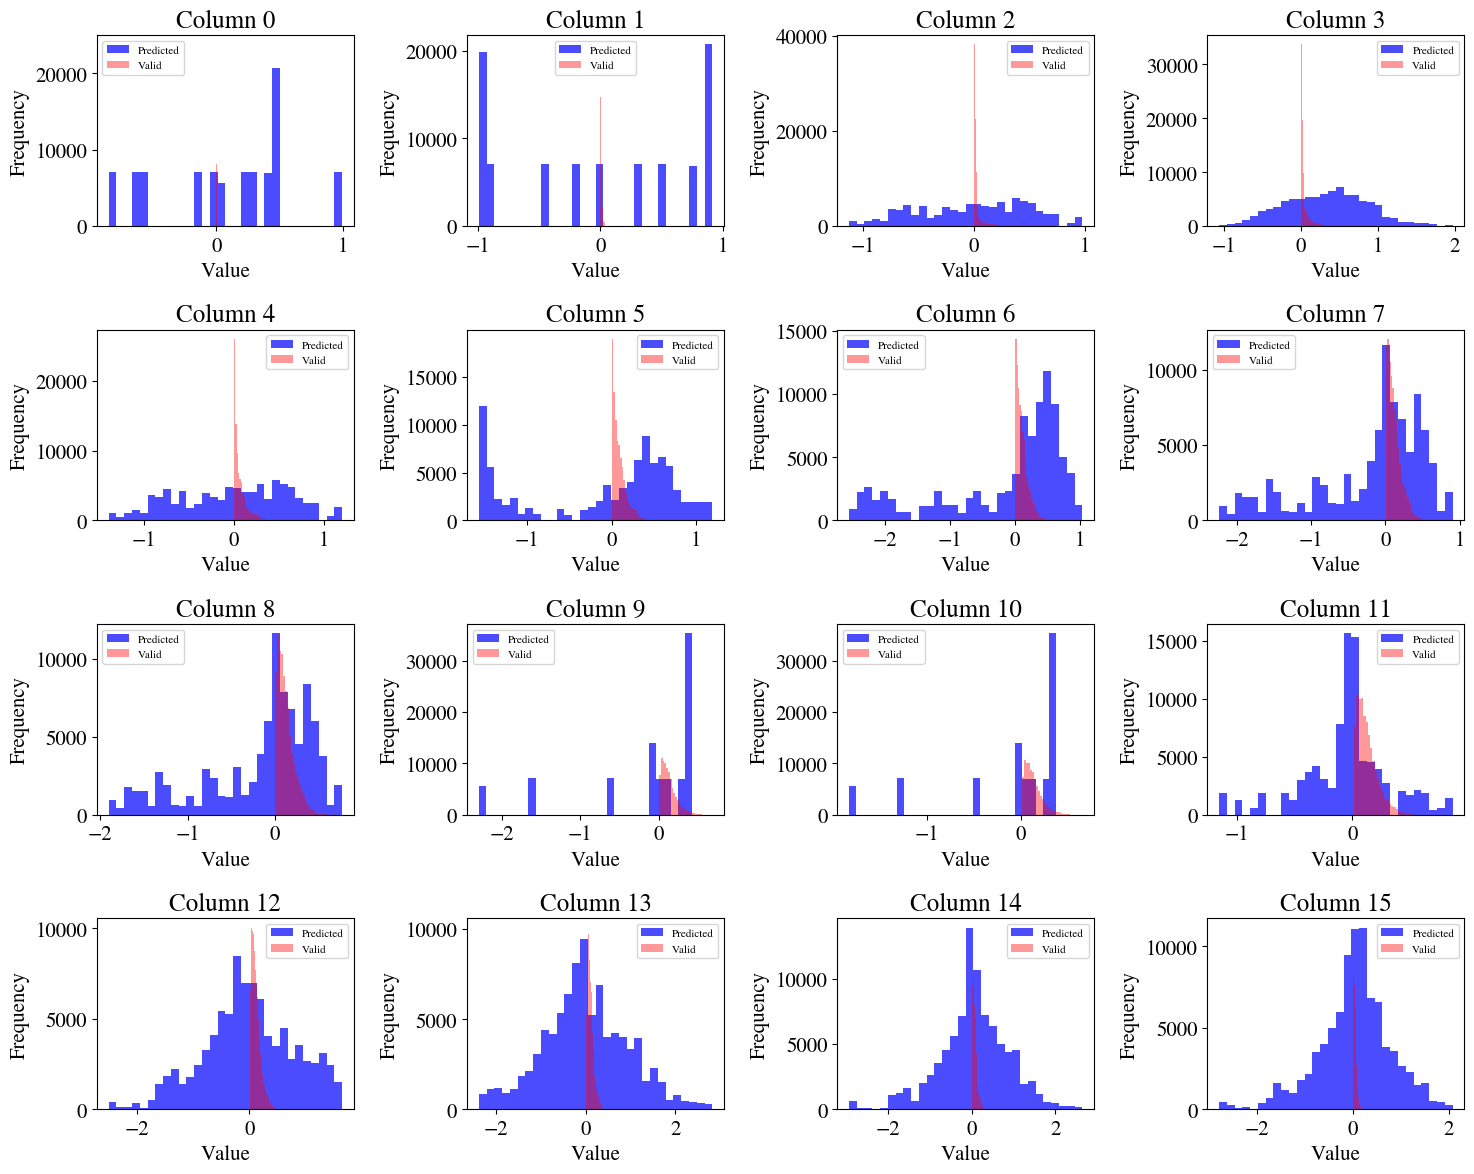

In [45]:


fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4x4 grid of subplots

for i in range(16):
    ax = axes[i // 4, i % 4]  # Determine subplot position
    ax.hist(y_pred_test[:, i], bins=30, alpha=0.7, color='b', label='Predicted')  # Blue histogram
    ax.hist(valid_y[:, i], bins=30, alpha=0.4, color='r', label='Valid')  # Red histogram with transparency
    ax.set_title(f'Column {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()  # Add legend to differentiate

plt.tight_layout()
plt.show()

While the validation error is small, the shape function is not preserved. Additionally, artifacts from data masking affect performance. Despite the low loss, a comparison of predicted and observed validation measurements reveals that the model is not functioning as expected.

# 4. Conclusion

Our study compared different machine learning methods for predicting shape function values, focusing on Stochatic Variational Gaussian Process and Symbolic Regression.

**Key Findings:**

**Gaussian Process Regression (GPR) vs. Neural Networks**
- GPR captures data dependencies explicitly through kernel functions, improving prediction accuracy.
- SVGP training took 35.6 minutes, achieving a validation RMSE of 0.5037.
- GPR outperformed the original neural network, particularly in nodes 1–6, where predictions were more concentrated and errors were minimal. However, for nodes 10–13, improvements were marginal due to challenges in capturing multi-modal distributions.

**Symbolic Regression**
- Symbolic regression performed worse than other ML methods in predictive accuracy and computational speed (80–120 min runtime).
- Despite poor performance, it offers high interpretability, making the derived equations easily integrable into ecosystem models without computational overhead.
- Potential improvements (e.g., more iterations, additional unary operators) would increase computational cost further.


**Feature Importance Analysis**
- SHAP analysis revealed Coriolis force (I₀) and Surface buoyancy flux (b₀₀) were the most influential features.
- SHAP results exhibited wide variability, limiting interpretability despite providing insights into feature interactions.
- Symbolic Regression supported these findings, as Coriolis force and Surface buoyancy were the only two features included in every 'best' equation
  

**Complexity, Performance, Interpretability**
While promising, the underperformance and high computational cost of symbolic regression limit its practicality in this context. However, further improvements could enhance its effectiveness. Ultimately, combining GPR with SHAP analysis provides a balance between accuracy and interpretability, outperforming traditional black-box ML models in both predictive performance and feature understanding.